In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [1]:

from ASCAM.src.core.idealization import Idealizer 

In [4]:
def parse_color(rgba):
    r, g, b = [i / 255 for i in rgba[:3]]
    return r, g, b, rgba[-1]
def rgba(r, g, b, a):
    return parse_color((r, g, b, a))
def state_colors(rgba, i, j):
    new_rgba = list(rgba)
    colors = []
    for c in range(6):
        new_rgba[i] += (30 / 255)
        new_rgba[j] += (30 / 255)
        color = tuple(new_rgba)
        colors.append(color)
    return colors
disc_color = rgba(9, 104, 203, 0.8)
tc_color = rgba(214, 0, 0, 0.8)
disc_state_colors = state_colors(disc_color, 0, 1)
tc_state_colors = state_colors(tc_color, 1, 2)

##  Data

In [68]:
gt = 'data/example/clean-traces/clean-current-trace-samplerate40000.npy'
trace = 'data/example/traces/current-trace-samplerate40000-SNR2_0-gf5000.npy'
fit = 'data/example/current-trace-samplerate40000-SNR2_0-gf5000_Alpha1e-06_ICHACBIC_ICdivsegBIC_minseg3_mincluster3_BICfull_.npy'
samplerate = 40000
tc_amplitudes = [0, -0.6, -1.2, -1.8, -2.5]

In [18]:
def load_simulation_results(path_ground_truth, path_trace, sample):
    trace = np.load(f"{path_trace}")*1e12  # in pA
    time = np.linspace(0, len(trace)/sample, len(trace))*1e3  # in ms
    ground_truth = np.load(f"{path_ground_truth}")*1e12  # pA
    return time, ground_truth, trace

In [53]:
def load_DISC_results(
    path, sample
):
    fit = np.load(
            f"{path}"
        )*1e12  # in pA
    time = np.linspace(0.5, 0.5+len(fit)/sample, len(fit))*1e3  # in ms
    return time, fit

## Figures

In [43]:
def simulation_results_figure(
    path_gt, path_trace, starttime, endtime, zoomin, sample
):
    #f, axes = plt.subplots(4, 2, layout='constrained', figsize=(8,4))
    f, a = plt.subplots(2, 1, layout='constrained')
    
    time, gt, trace = load_simulation_results(path_gt, path_trace, sample)
    start = np.argmax(time >= starttime)
    end = np.argmax(time >= endtime)
    a[0].plot(time[start:end], gt[start:end], linewidth=0.4, color='green', label='ground truth', alpha=0.7)
    a[0].plot(time[start:end], trace[start:end], linewidth=0.4, color='black', label='trace', alpha=0.7)
    a[0].axis("off")
    a[0].set_ylim(-3.1, 0.4)
    a[0].set_xlim(starttime-20, endtime)
    a[0].vlines(zoomin[0], -3, 1, 'grey', linestyle='dashed')
    a[0].vlines(zoomin[1], -3, 1, 'grey', linestyle='dashed')
    a[0].hlines(-3, zoomin[0], zoomin[1], 'grey', linestyle='dashed')
    a[0].hlines(0.3, zoomin[0], zoomin[1], 'grey', linestyle='dashed')
    start2 = np.argmax(time >= zoomin[0])
    end2 = np.argmax(time >= zoomin[1])
    a[1].plot(time[start2:end2], gt[start2:end2], linewidth=0.9, color='green', label='ground truth', alpha=0.7)
    a[1].plot(time[start2:end2], trace[start2:end2], linewidth=0.9, color='black', label='trace', alpha=0.7)
    a[1].axis("off")
    a[1].set_xlim(zoomin[0], zoomin[1])
    ymin = np.min(trace[start2:end2])
    ymax = np.max(trace[start2:end2])
    a[1].set_ylim(ymin, ymax)
        
    a[0].hlines(-2.5, starttime+60, starttime+160, 'k')
    a[0].vlines(starttime+60, -2.5, -1.5, 'k')
    a[0].text(starttime-8, -2.4, "1 pA")
    a[0].text(starttime+60, -3.6, "100 ms")

    a[1].hlines(ymin+0.1, zoomin[0]+7, zoomin[0]+12, 'k')
    a[1].vlines(zoomin[0]+7, ymin+0.1, ymin+0.6, 'k')
    a[1].text(zoomin[0], ymin+0.2, "0.5 pA")
    a[1].text(zoomin[0]+7.5, ymin*1.35, "5 ms")
    a[0].legend(loc="upper right")
    return f, a

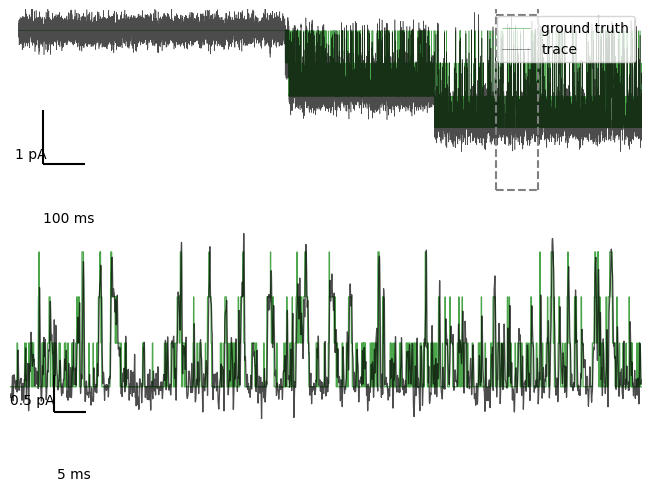

In [69]:
f, a = simulation_results_figure(
    gt,
    trace,
    500, 2000,
    (1650, 1750),
    samplerate
)

In [57]:
def disc_fit_results_figure(
    fitpath, gtpath, tracepath, sample, zoomin1, zoomin2
):
    fulltime, gt, trace = load_simulation_results(gtpath, tracepath, sample=sample)
    truestates = np.unique(gt)
    f, ax = plt.subplots(3, 1, layout='constrained')
    time, fit = load_DISC_results(fitpath, sample)
        
    fitstates = np.unique(fit)
    nfit = len(fit)
    ax[0].plot(fulltime[-1*nfit:], trace[-1*nfit:], linewidth=0.4, alpha=0.7, color='darkgrey', label='trace')
    ax[0].plot(fulltime[-1*nfit:], gt[-1*nfit:], linewidth=0.4, alpha=0.7, color='green', label='ground truth')
    ax[0].plot(time, fit, linewidth=0.4, alpha=0.7, color=disc_color, label='DISC fit')
        
    ax[0].hlines(truestates, 500, 2000, color='grey', linewidth=0.4)
    ax[0].hlines(fitstates, 500, 2000, color=disc_state_colors[2], linewidth=0.4)
    ax[0].axis("off")

    for i, zoomin in enumerate((zoomin1, zoomin2)):
        ax[i].vlines(zoomin, -2.5, 0, 'k', linewidth=1.5)
        ax[i].hlines([-2.5, 0], zoomin[0], zoomin[1], 'k', linewidth=1.5)
        ax[i].text(
            zoomin[0] + (zoomin[1] - zoomin[0])/2, 0.3, f"{zoomin[1] - zoomin[0]} ms", 
            horizontalalignment='center',verticalalignment='center'
        )
            
        fitstartdidx = np.where(time >= zoomin[0])[0][0]
        fitendidx = np.where(time <= zoomin[1])[0][-1]
        tracestartdidx = np.where(fulltime >= zoomin[0])[0][0]
        traceendidx = np.where(fulltime <= zoomin[1])[0][-1]
        ax[i+1].plot(
            fulltime[tracestartdidx:traceendidx], trace[tracestartdidx:traceendidx],
            linewidth=0.9, alpha=0.7, color='darkgrey'
        )
        ax[i+1].plot(
            fulltime[tracestartdidx:traceendidx], gt[tracestartdidx:traceendidx],
            linewidth=0.9, alpha=0.7, color='green'
        )
        ax[i+1].plot(
            time[fitstartdidx:fitendidx], fit[fitstartdidx:fitendidx],
            linewidth=0.9, alpha=0.7, color=disc_color
        )
        ax[i+1].hlines(truestates, zoomin[0], zoomin[1], color='grey', linewidth=0.4)
        ax[i+1].hlines(fitstates, zoomin[0], zoomin[1], color=disc_state_colors[2], linewidth=0.4)
        ax[i+1].axis("off")

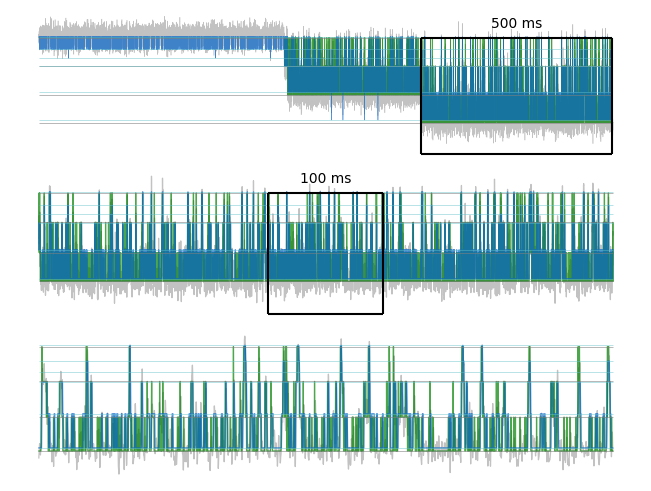

In [70]:

disc_fit_results_figure(
    fit,
    gt,
    trace,
    samplerate, (1500, 2000), (1700, 1800)
)

In [78]:
def tc_results_figure(
    gtpath, tracepath, sample, amplitudes, zoomin1, zoomin2, resolution
):
    # f, axes = plt.subplots(3, 1, layout='constrained', figsize=(8, 4))
    f, axes = plt.subplots(3, 1, layout='constrained',figsize=(8,5))
    time, gt, trace = load_simulation_results(gtpath, tracepath, sample=sample)
    idealization, itime = Idealizer.TC_idealize_trace(trace, time, amplitudes, resolution=resolution)
    assert all(time ==  itime)
    axes[0].plot(time, trace, linewidth=0.4, alpha=0.7, color='darkgrey', label="trace")
    axes[0].plot(time, gt, linewidth=0.4, alpha=0.7, color='green', label="ground truth")
    axes[0].plot(time, idealization, linewidth=0.4, alpha=0.7, color=tc_color, label="TC fit")
    axes[0].axis("off")
    for i, (zoomin, ax) in enumerate(zip((zoomin1, zoomin2), axes[1:])):
        axes[i].vlines(zoomin, -2.5, 0, 'k', linewidth=1.5)
        axes[i].hlines([-2.5, 0], zoomin[0], zoomin[1], 'k', linewidth=1.5)
        axes[i].text(
            zoomin[0] + (zoomin[1] - zoomin[0])/2, 0.3, f"{zoomin[1] - zoomin[0]} ms", 
            horizontalalignment='center',verticalalignment='center'
        )
        starttime, endtime = zoomin
        startid = np.where(time >= starttime)[0][0]
        endid = np.where(time <= endtime)[0][-1]
        ax.plot(time[startid:endid], trace[startid:endid], linewidth=0.9, alpha=0.7,color='darkgrey')
        ax.plot(time[startid:endid], idealization[startid:endid], linewidth=0.9, alpha=0.7, color=tc_color)
        ax.plot(time[startid:endid], gt[startid:endid], linewidth=0.9, alpha=0.7,color='green')
        ax.axis("off")

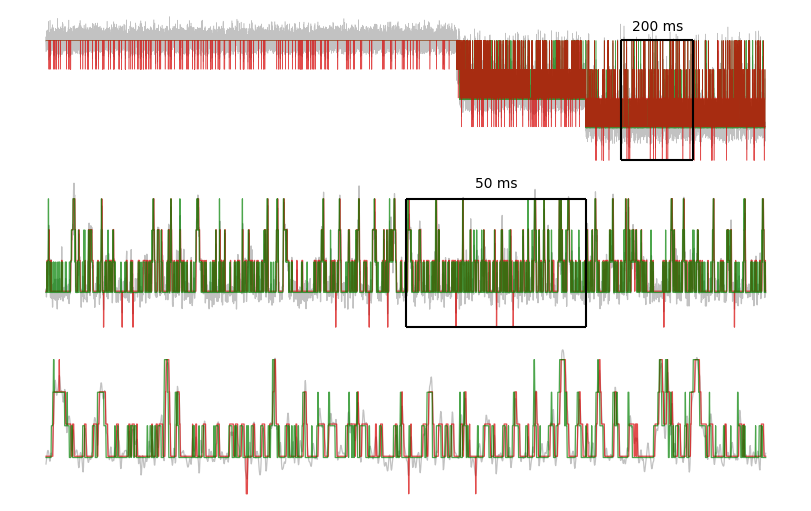

In [80]:
tc_results_figure(
    gt, trace, samplerate, tc_amplitudes, (1600, 1800), (1700, 1750), resolution=0.13*1e-3
)

In [105]:
def dwell_times_figure(
    gt, trace, sample,
    amplitudes, tcfilter, resolution,
    fit, n,
):
    time, gt, trace = load_simulation_results(gt, trace, sample=sample)
    tcfit, tctime = Idealizer.TC_idealize_trace(trace, time, amplitudes, resolution=resolution)
    disctime, discfit = load_DISC_results(fit, sample=sample)
    f, ax = plt.subplots(
        layout='constrained', figsize=(8,6))
    for fit, t, color, label in zip(
        (gt, tcfit, discfit), (time, tctime, disctime), ('green', tc_color, disc_color), ('sim.', 'TC', 'DISC')
    ):
        print(np.std(fit))
        startid = np.where(t >= 500)[0][0]
        events_table = Idealizer.extract_events(fit[startid:], t[startid:])  # columns: amplitudes, durations, start, end
        states = np.sort(np.unique(fit))[-1::-1]
        print([round(s, 2) for s in states])
        count = 0
        for i, state in enumerate(states):
            if i != n:
                continue
            ax.set_title(f"{round(state, 1)} pA")
            eventids = np.where(events_table[:,0] == state)[0]
            durations = events_table[eventids, 1]
            nbins = round(3.49 * np.std(durations) * len(durations) ** (1 / 3))
            if nbins == 0:
                nbins = 5
            f2, a2 = plt.subplots()
            hist, bins, _ = a2.hist(durations, bins=nbins)
            logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
            hist, bins, _ = a2.hist(durations,alpha=0.4, bins=logbins)
            plt.close()
            x = bins[1:] + (bins[1:] - bins[:-1]) / 2
            y = hist.view()
            ax.set_xscale('log')
            #ax.scatter(x, y*1/2, color=color)
            if label == 'sim.':
                tcfilter = tcfilter or 10e3
                ax.vlines(0.3321/tcfilter*1e3, 0, 42, color='grey', linestyle='dashed')#, label="T$_r$")
            ax.plot(x, y, color=color, label=label, alpha=0.6)
            print(f"{len(durations)} events at state {i} for {label}")
            count += len(durations)
            ax.set_xlabel("Dwell time [ms]")
            ax.set_ylabel("Counts")
            ax.legend()
        print(f"{count} events in total for {label}")
    

0.7231142800549384
[-0.0, -0.61, -1.23, -1.82]
858 events at state 3 for sim.
858 events in total for sim.
0.7149266109846909
[0.0, -0.6, -1.2, -1.8, -2.5]
669 events at state 3 for TC
669 events in total for TC
0.7180653636919873
[0.02, -0.25, -0.44, -0.62, -1.17, -1.77]
621 events at state 3 for DISC
621 events in total for DISC


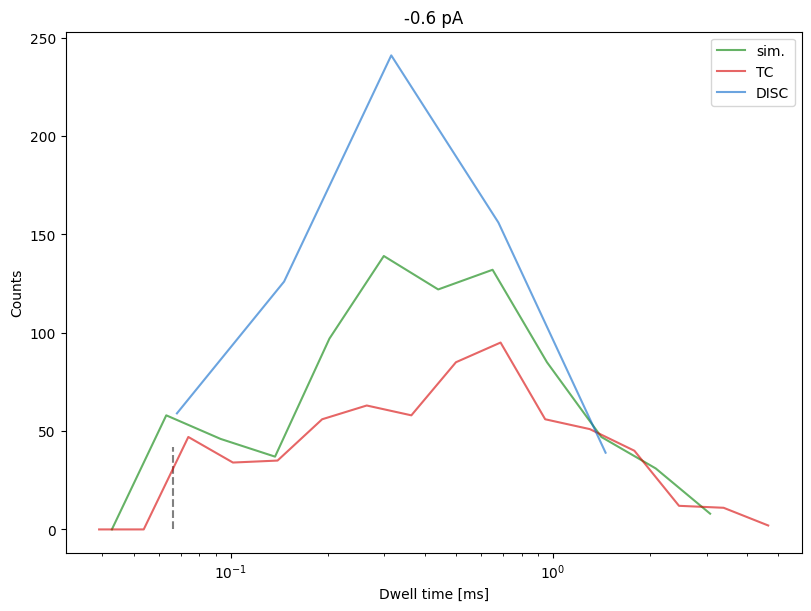

In [106]:
s = 1
dwell_times_figure(
    gt, trace, samplerate, tc_amplitudes, 5e3, 
    0.13*1e-3, fit, 3
)